1D Maxwell equations
===========

Maxwell's equations read (speed of light = 1):

$$
\partial_t\vec B = -\mathrm{rot}\vec E\\
\partial_t\vec E = \mathrm{rot}\vec B
$$

Writing all the components we get for magnetic field:

$$
\partial_t B_x = -\left(\partial_y E_z - \partial_z E_y \right)\\
\partial_t B_y = -\left(\partial_y E_x - \partial_z E_z \right)\\
\partial_t B_z = -\left(\partial_y E_y - \partial_z E_x \right)\\
$$

And for electric field:
$$
\partial_t E_x = \left(\partial_y B_z - \partial_z B_y \right)\\
\partial_t E_y = \left(\partial_y B_x - \partial_z B_z \right)\\
\partial_t E_z = \left(\partial_y B_y - \partial_z B_x \right)\\
$$

Assume 1D geometry, i.e. everything depends only on $t$ and $x$ (infinitely large electromagnetic waves in $y$ and $z$ dimensions). Then we get:

$$
\partial_t B_y = \partial_x E_z\\
\partial_t B_z = -\partial_x E_y
$$

and 

$$
\partial_t E_y= - \partial_x B_z\\
\partial_t E_z= \partial_x B_y
$$

One can see, that these 4 equations can be split into two parts (they are called polarizations of the wave): $E_y, B_z$ (p-polarization) and $E_z, B_y$ (s-polarization)

We get two separate and completely independent sets of equations:

1. P-polarization
-----------------

$$
\partial_t E_y= - \partial_x B_z\\
\partial_t B_z = -\partial_x E_y
$$

2. S-polarization
-----------------

$$
\partial_t E_z= \partial_x B_y\\
\partial_t B_y = \partial_x E_z
$$


Task 1
------

Before proceeding with numerical solution of these equations (let us for simplicity and saving time only deal with p-polarization today) think of a numerical scheme how to solve equations. There are many numerical methods to do this, but can you without looking further in the text come up with one? 

Tip: if you understand what a fractional (1/2) time or spatial step means - you can use it.

#### My answer

I know a simple explicit scheme for that. It consists in replacing the partial derivatives with finite differences. Let $E'_i$ denote the value of the field in lattice site $i$ on the next time step. Then we can find it in the following way:

$$
E'_i = E_i - \frac{\tau}{2 \Delta x} (B_{i+1} - B_{i-1}).
$$

Same for $B'$.

Numerical scheme
----------------

Let's look again at the equations for p-polarization:
$$
\partial_t E_y= - \partial_x B_z\\
\partial_t B_z = -\partial_x E_y
$$

Lets sum equations and substract equations and use notation $F_+=E_y+B_z$ and $F_-=E_y-B_z$:

$$
\left(\partial_t + \partial_x\right)F_+ = 0\\
\left(\partial_t - \partial_x\right)F_- = 0
$$

Task 2
------

One of the new fields $F_+$ and $F_-$ corresponds to the wave going from left to right and one to the wave going from right to left. Which is which?

#### My answer

Consider the second equation. The derivative on time is equal to the derivative on space. This is possible when $F$ is a function of $x + t$. On the $x, t$ plane the function is consant along the straight lines $x + t = C$, or, equivalently, $x = C - t$ which is a trajectory moving to the left. So, the first equation propagates waves to the right, the second one -- to the left.

Task 3
------

Derive the numerical scheme (consider the time step equals to spatial step, i.e. $\Delta t$ = $\Delta x$):

$$
F_{+,i}^{n+1} = F_{+,i-1}^n\\
F_{-,i}^{n+1} = F_{-,i+1}^n
$$

#### My answer

Replace the time derivative with forward finite difference, and the space derivative with the backward space derivative (I omit indices if they correspond to "current" space or time position):

$$
\frac{1}{\Delta t}(F_+^{n+1} - F_+) + \frac{1}{\Delta x} (F_+ - F_{+, i-1}) = 0.
$$
For equal space and time stepsizes, the $F_+$ cancel out and yield the desired scheme. 

For $F_-$, you need a forward space derivative.

Task 4
------

Consider 1D computational domain of length $L=2\pi \cdot 40$ (you can vary the numbers later), consider only  $F_+$

$$
\Delta t = \Delta x = \frac{2\pi}{1000}
$$

Initially there are no fields in the computational domain.

Boundary condition:

$$
F_+(x=0,t)=sin(t),\quad \mathrm{if}\quad t<2\pi\cdot 10\\
F_+(x=0,t)=0, \mathrm{otherwise}
$$

Write a code (for example in Python for prototyping) that solves 1D Maxwell equations.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from numba import jit, njit

In [2]:
dt = np.pi / 100
dx = dt
L = 2 * np.pi * 40
N = int(L // dx)
t_max = 40 * np.pi * 2
n_steps = int(t_max / dt)



def f_boundary(t):
    """Boundary condition on the left wall. 
    We don't care about the right wall right now"""
    return np.sin(t) if t < 2 * np.pi * 10 else 0



In [3]:
%%time

f_plus_total = []
initial_conditions = [0] * N
f_plus_total.append(initial_conditions)

@njit
def timestep(old_sol, t):
#     new_solution = deepcopy(old_sol)
#     new_solution.pop(-1)
#     new_solution = [f_boundary(i * dt)] + new_solution
    new_solution = np.zeros(N)
    new_solution[0] = np.sin(t) if t < 2 * np.pi * 10 else 0
    for j in range(1, N):
        new_solution[j] = old_sol[j - 1]
    return new_solution

for i in range(1, n_steps):
    new_solution = timestep(f_plus_total[-1], i * dt)
    f_plus_total.append(new_solution)


CPU times: user 679 ms, sys: 196 ms, total: 875 ms
Wall time: 966 ms


701 ms with njit, 18.4 s without it

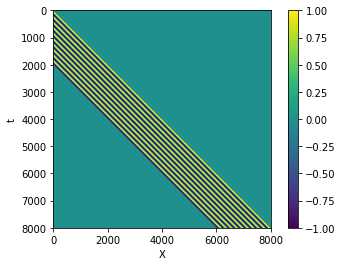

In [4]:
plt.imshow(f_plus_total)
plt.xlabel('X')
plt.ylabel('t')
plt.colorbar()

I took a coarser time step, but I think the idea is clear.

Task 5
------

Write a code in C/C++ and parallelize it using OpenMP.

The code can be found in `maxwell.c` and `maxwell_mp.c`. 

In [5]:
omp = np.loadtxt('out.txt')

In [6]:
np.shape(omp)

(99, 3999)

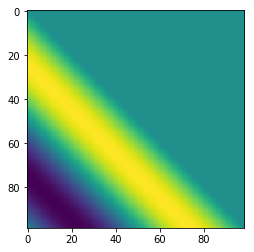

In [7]:
plt.imshow(omp[:, :99])